In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button

TOLERANCE = 0.20

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points
        
    def get_points(self):
        return self.points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]

    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        
%matplotlib notebook

# Zad 2.1

## Dostosuj aplikację graficzną tak, aby można było zadawać proste wielokąty przy użyciu myszki, z dodatkowym zapisem i odczytem podanych wielokątów. Wielokąty powinny być zadawane w kierunku przeciwnym do ruchu wskazówek zegara.

In [3]:
def get_points_from_plot(plot):
        points = [] 
        lines = plot.get_added_figure()[0].lines
        for line in lines:
            points.append(line[0])
        #points.append(lines[len(lines)-1][1])
        return points
def points_to_lines(points):
    lines = []
    for i in range(len(points)):
        lines.append((points[i-1],points[i]))
    return lines

<IPython.core.display.Javascript object>


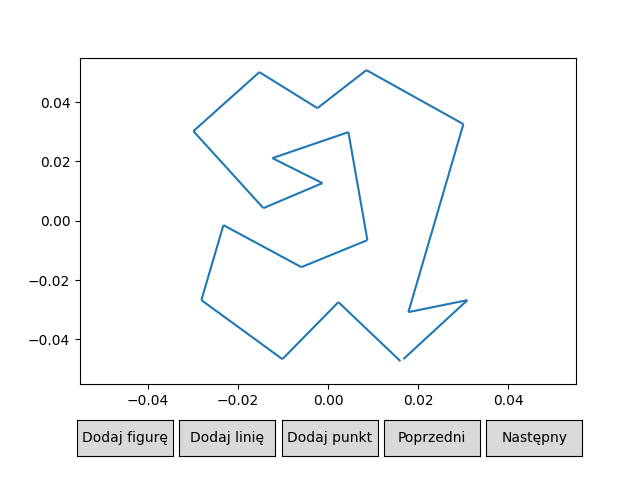

In [5]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [6]:
data1=get_points_from_plot(plot)

<IPython.core.display.Javascript object>


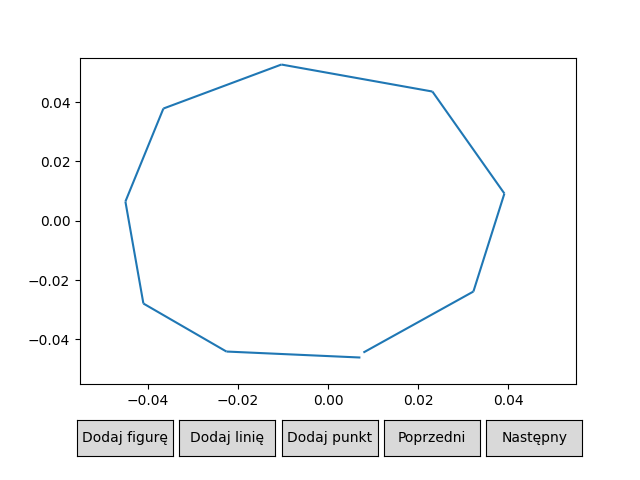

In [7]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [8]:
data2=get_points_from_plot(plot)

<IPython.core.display.Javascript object>


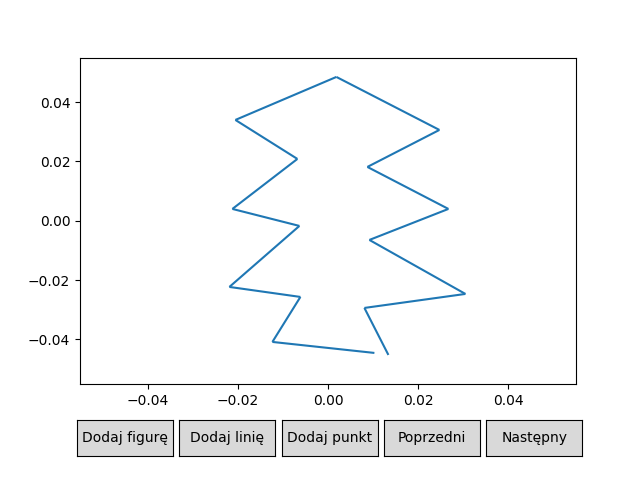

In [9]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [10]:
data3 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


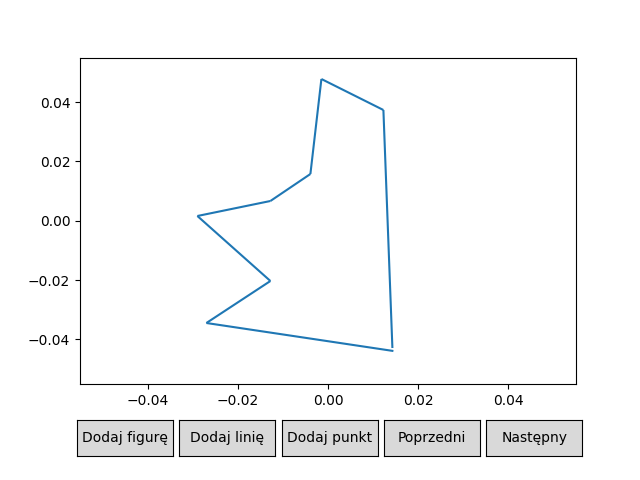

In [54]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [55]:
data4 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


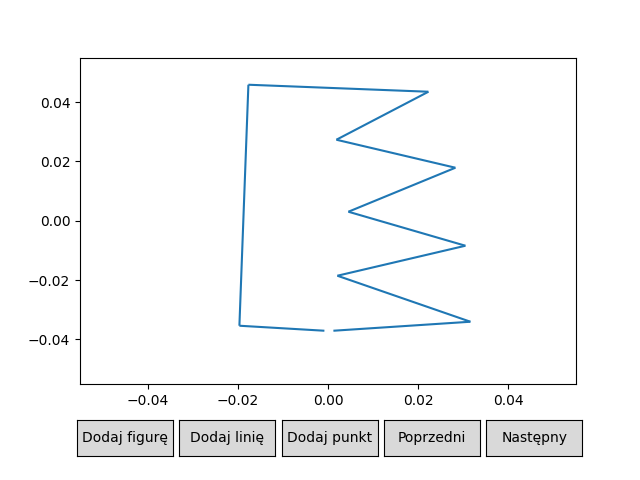

In [13]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [14]:
data5 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


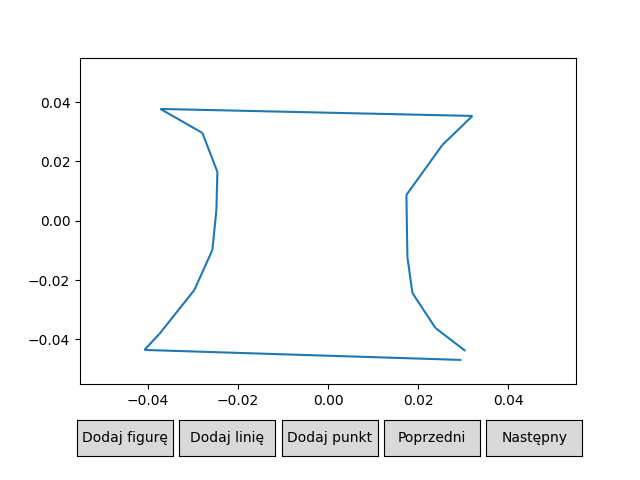

In [61]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [62]:
data6 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


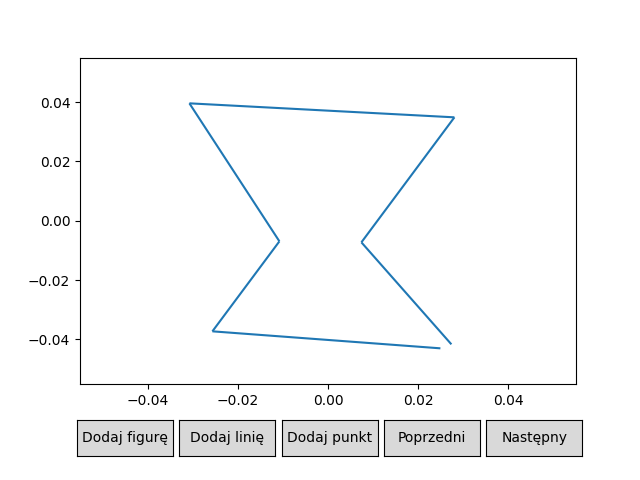

In [70]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [71]:
data7 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


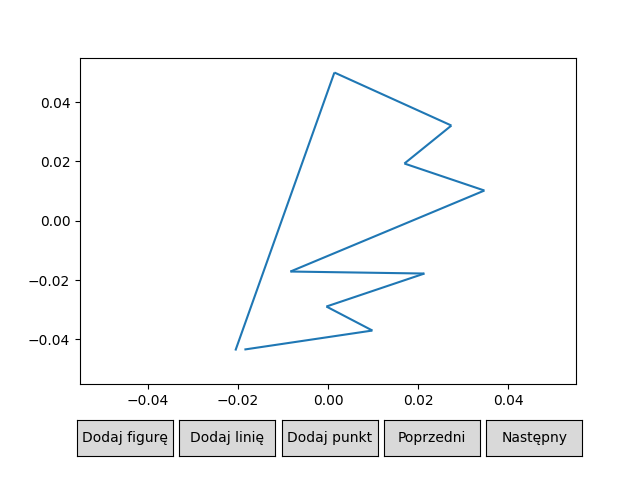

In [4]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [5]:
data8 = get_points_from_plot(plot)

<IPython.core.display.Javascript object>


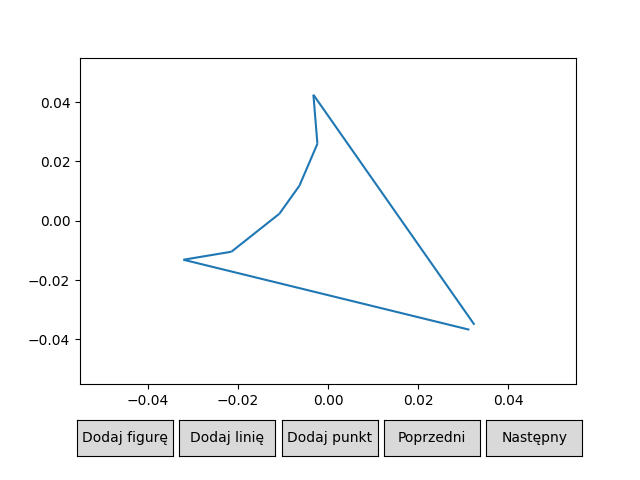

In [48]:
plot = Plot(scenes=[Scene()])
plot.draw()

In [49]:
data9 = get_points_from_plot(plot)

# Zad 2.2

## Zaimplementuj procedurę sprawdzającą, czy podany wielokąt jest y-monotoniczny. W sprawozdaniu opisz krótko tę metodę sprawdzania.

In [8]:
def maxY_index(points):
    maximum=float('-inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]>maximum:
            maximum=points[i][1]
            index=i
    return index

def minY_index(points):
    minimum=float('inf')
    index=-1
    for i in range(len(points)):
        if points[i][1]<minimum:
            minimum=points[i][1]
            index=i
    return index

In [9]:
def yMonotony(points):
    top=maxY_index(points)
    bottom=minY_index(points)
    i=top
    while i != bottom:
        next_point=(i+1)%len(points)
        if points[next_point][1]>points[i][1]:
            return False       
        i=next_point
    i=bottom
    
    i=bottom
    while i != top:
        next_point=(i+1)%len(points)
        if points[next_point][1]<points[i][1]:
            return False       
        i=next_point
        
    return True

In [17]:
yMonotony(data1)

False

In [18]:
yMonotony(data2)

True

In [19]:
yMonotony(data3)

True

In [20]:
yMonotony(data4)

True

In [21]:
yMonotony(data5)

True

In [63]:
yMonotony(data6)

True

In [72]:
yMonotony(data7)

True

In [10]:
yMonotony(data8)

True

In [11]:
yMonotony(data9)

True

# Pkt 2.3

## Zaimplementuj algorytm, który dla zadanego wielokąta będzie wyszukiwał wierzchołki początkowe, końcowe, łączące, dzielące i prawidłowe. Wierzchołki mają zostać odpowiednio pokolorowane zgodnie z klasyfikacją.

In [12]:
epsilon = 10**(-12)
def matrix_2x2(a,b,c):
    return [[a[0]-c[0], a[1]-c[1]], [ b[0]-c[0], b[1]-c[1]]]

def det_2x2(a,b,c):
    matrix=matrix_2x2(a,b,c)
    return (matrix[0][0]*matrix[1][1])-(matrix[0][1]*matrix[1][0])

def more_than_pi(a,b,c):
    if (det_2x2(a,b,c))<-epsilon:
        return True
    return False

In [13]:
START = 0
END = 1
CONNECT = 2
DIVIDING = 3
CORRECT = 4
def classify_points(points):
    classified = [ [], [], [], [], [] ]

    for current in range(len(points)):
        nextP=(current+1)%len(points)
        previous=current-1
        if points[previous][1] < points[current][1] and points[nextP][1] < points[current][1]:
            if more_than_pi(points[previous],points[current],points[nextP]):
                classified[DIVIDING].append(points[current])
            else:
                classified[START].append(points[current])
        elif points[previous][1] > points[current][1] and points[nextP][1] > points[current][1]:
            if more_than_pi(points[previous],points[current],points[nextP]):
                classified[CONNECT].append(points[current])
            else:
                classified[END].append(points[current])
        else:
            classified[CORRECT].append(points[current])
    return classified

In [14]:
def color_classified_points(all_points):
    classified=classify_points(all_points)
    plot = Plot(points= [PointsCollection(classified[START],color = "green"),
                        PointsCollection(classified[END], color = "red"),
                        PointsCollection(classified[CONNECT], color = "darkblue"),
                        PointsCollection(classified[DIVIDING], color = "lightblue"),
                        PointsCollection(classified[CORRECT], color = "brown", marker= "D")],
               lines =[LinesCollection(points_to_lines(all_points),color="black")])
    plot.draw()

<IPython.core.display.Javascript object>


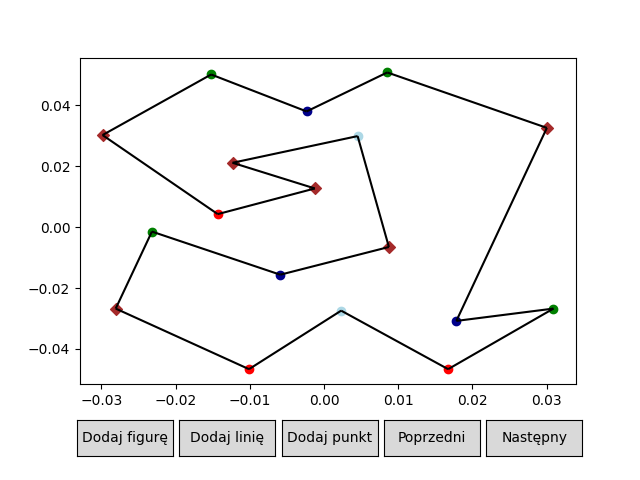

In [77]:
color_classified_points(data1)

<IPython.core.display.Javascript object>


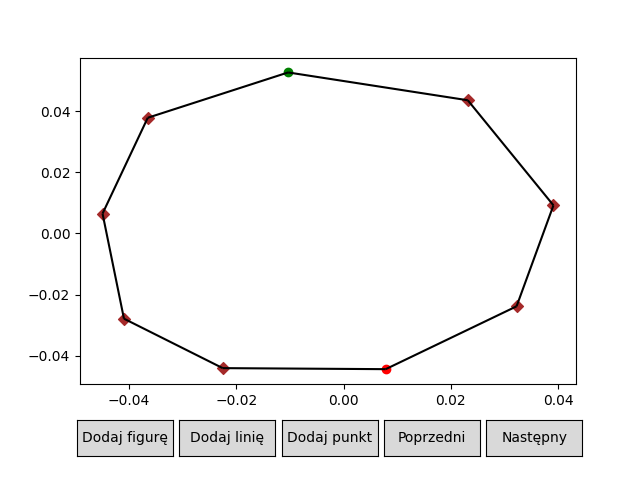

In [78]:
color_classified_points(data2)

<IPython.core.display.Javascript object>


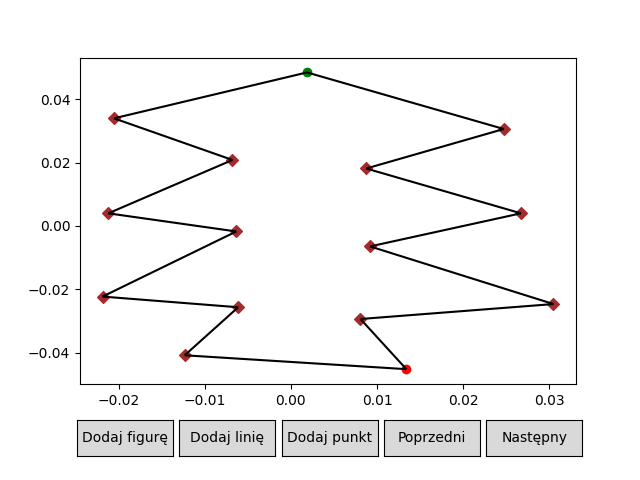

In [79]:
color_classified_points(data3)

<IPython.core.display.Javascript object>


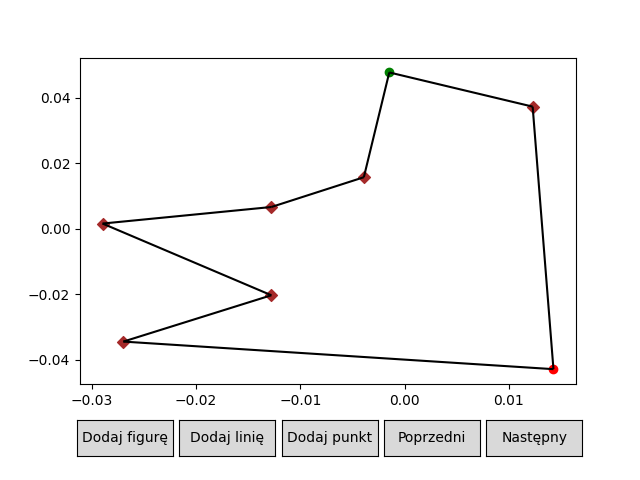

In [80]:
color_classified_points(data4)

<IPython.core.display.Javascript object>


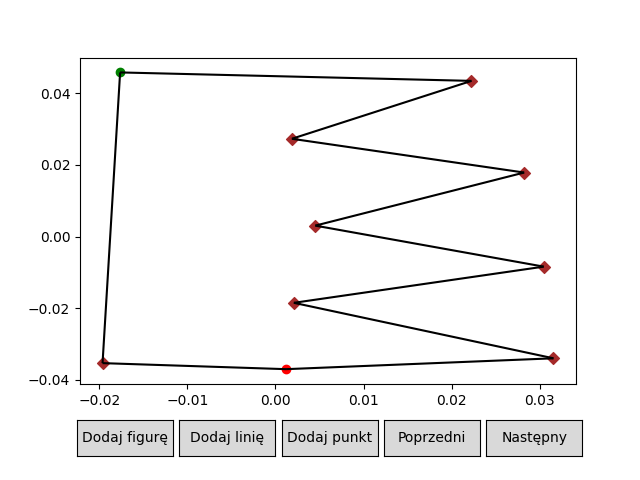

In [81]:
color_classified_points(data5)

<IPython.core.display.Javascript object>


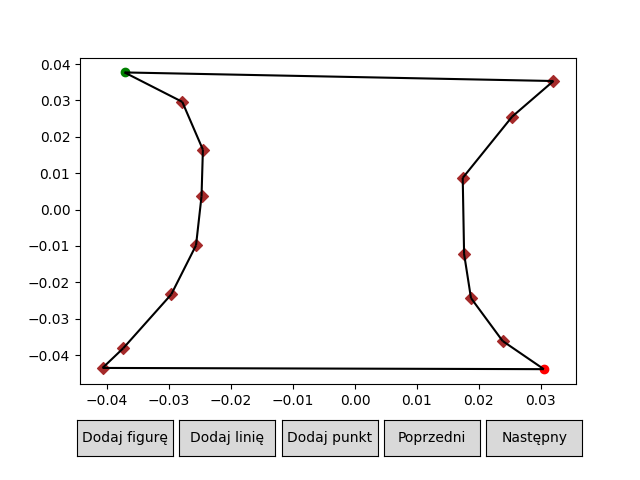

In [82]:
color_classified_points(data6)

<IPython.core.display.Javascript object>


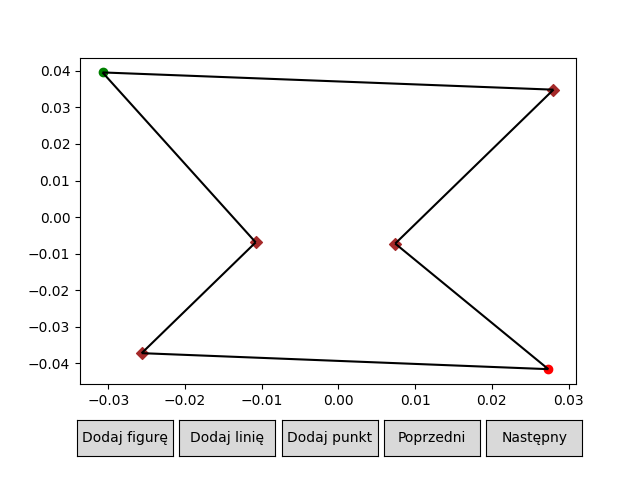

In [100]:
color_classified_points(data7)

<IPython.core.display.Javascript object>


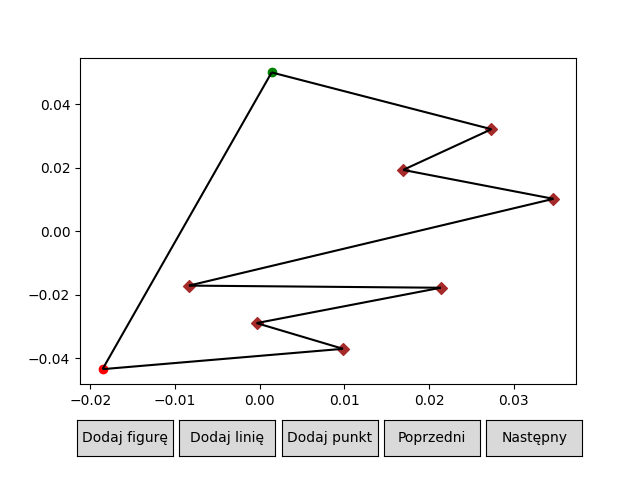

In [17]:
color_classified_points(data8)

<IPython.core.display.Javascript object>


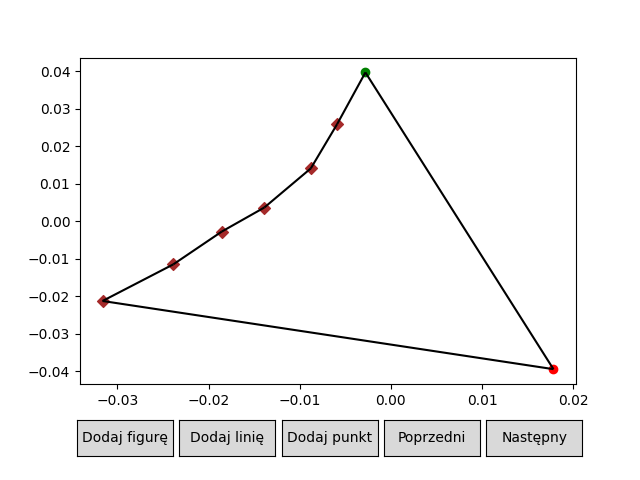

In [18]:
color_classified_points(data9)

# Zad 2.4

## Zaimplementuj procedurę triangulacji wielokąta monotonicznego (zgodnie z algorytmem opisanym na wykładzie). Program powinien pokazywać kolejne kroki algorytmu (tzn. kolejne tworzone trójkąty).

In [19]:
def is_in_polygon(a,b,c, number):
    if number == 0:
        return det_2x2(a,b,c) > epsilon
    else:
        return det_2x2(a,b,c) <- epsilon

In [37]:
def triangulation(points):
    if not yMonotony(points):
        print("Wielokat nie jest y-monotoniczny")
        return None, None
    
    maximum_index = maxY_index(points)
    minimum_index = minY_index(points)
    
    specified_points= []
    i=maximum_index
    while i!=minimum_index:
        specified_points.append((points[i],0,i))
        i=(i+1)%len(points)
    while i!=maximum_index:
        specified_points.append((points[i],1,i))
        i=(i+1)%len(points)
    specified_points.sort(reverse = True, key = lambda x: x[0][1])
    
    diagonals = []
    stack = []
    scenes = []
    diagonal_index=[]
    
    stack.append(specified_points[0])
    stack.append(specified_points[1])
    diagonals.append([specified_points[0][0], specified_points[1][0]])
    diagonal_index.append((specified_points[0][2],specified_points[1][2]))
 
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[0][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))    
    scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[1][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
    
    for i in range(2, len(specified_points)):
        if stack[-1][1] != specified_points[i][1]:
            while len(stack) > 0:
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2],specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(specified_points[i-1])
            stack.append(specified_points[i])
        else:
            new_verticle = stack.pop()
            diagonals.append([specified_points[i][0], new_verticle[0]])
            diagonal_index.append((specified_points[i][2],new_verticle[2]))
            scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            while len(stack) > 0 and is_in_polygon(specified_points[i][0], stack[-1][0], new_verticle[0], specified_points[i][1]):
                new_verticle = stack.pop()
                diagonals.append([new_verticle[0], specified_points[i][0]])
                diagonal_index.append((new_verticle[2], specified_points[i][2]))
                scenes.append(Scene([PointsCollection(points), PointsCollection([specified_points[i][0]], color="red", marker="D")], [LinesCollection(diagonals.copy(), color="black")]))
            stack.append(new_verticle)
            stack.append(specified_points[i])
  
    final_scene = Scene([PointsCollection(points)], [LinesCollection(diagonals.copy(), color="black")])
    scenes = [final_scene] + scenes
                        
    return diagonal_index, scenes

<IPython.core.display.Javascript object>


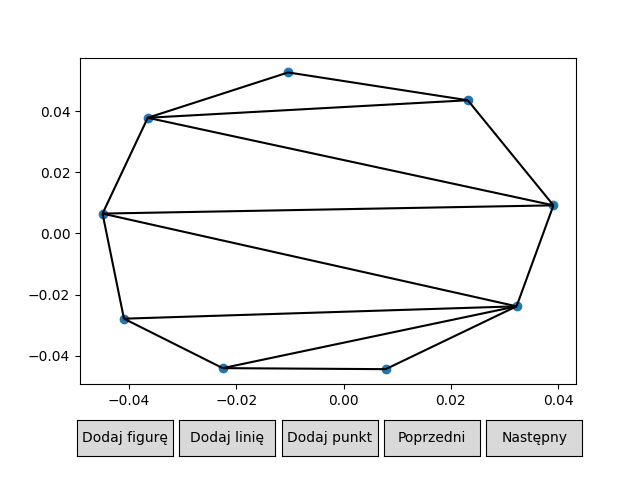

In [95]:
_, data = triangulation(data2)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


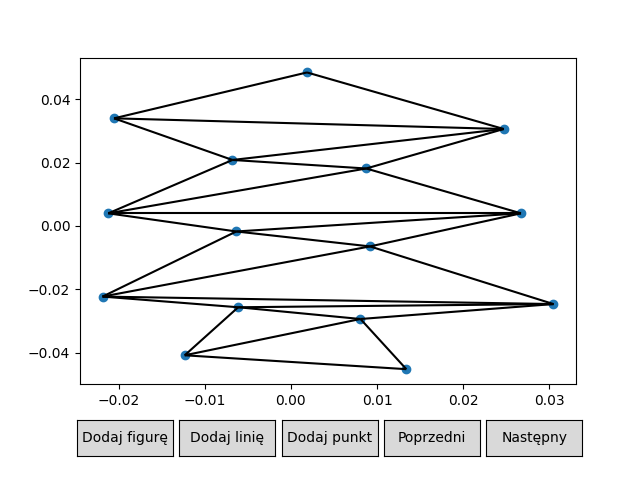

In [102]:
_, data = triangulation(data3)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


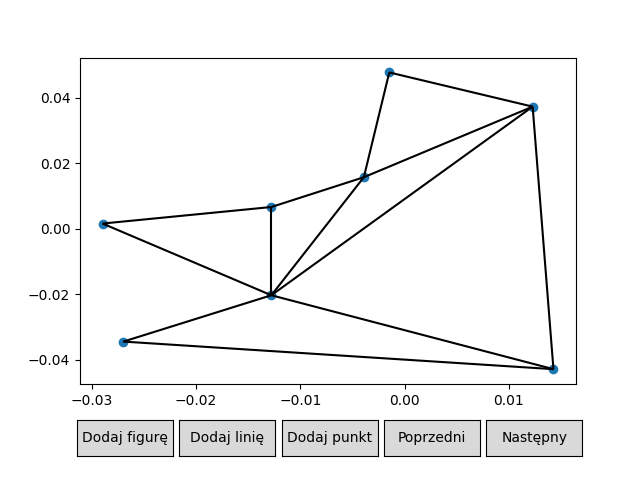

In [109]:
_, data = triangulation(data4)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


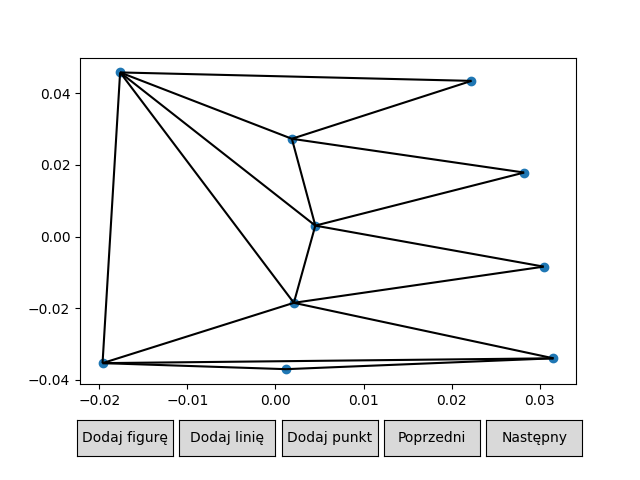

In [111]:
_ , data = triangulation(data5)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


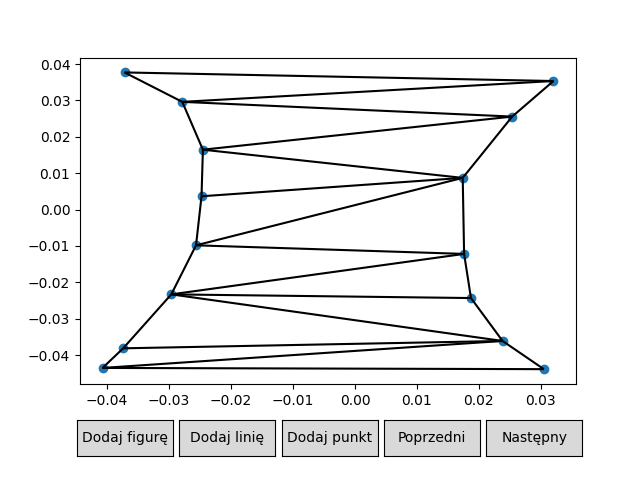

In [112]:
_ , data = triangulation(data6)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


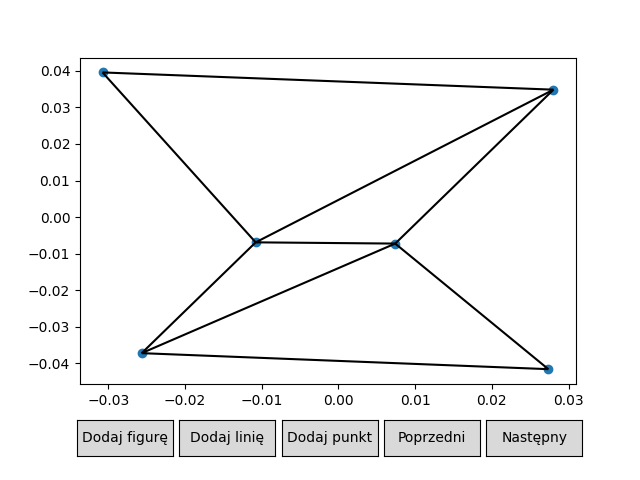

In [106]:
_ , data = triangulation(data7)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


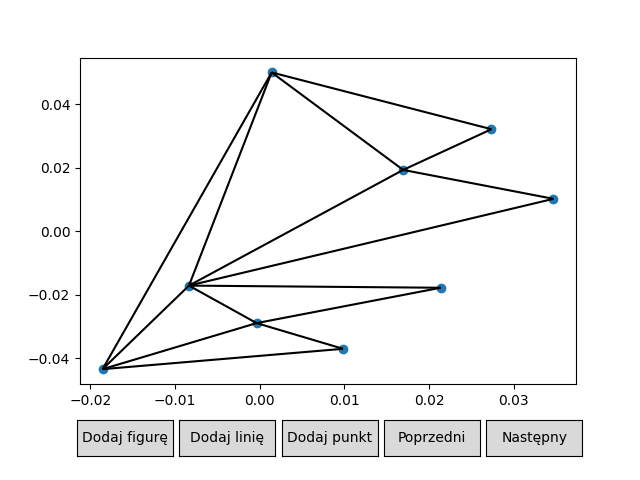

In [52]:
indexes , data = triangulation(data8)
plot = Plot(data)
plot.draw()

<IPython.core.display.Javascript object>


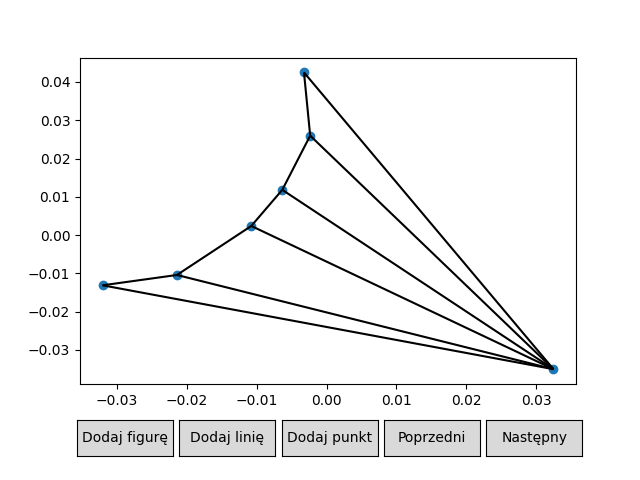

In [50]:
indexes , data = triangulation(data9)
plot = Plot(data)
plot.draw()